## conda environments

When accessing this notebook via the JASMIN Jupyter Notebook service, select the correct conda environment from the list of available kernels.

## Imports

In [2]:
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from data_classes import HealthData

## Code

### Mortality
Monthly data across England & Wales; by age, sex, region. Processed to look specifically at London region (all ages, all sexes).

In [3]:
home_folder = path.join(path.abspath(""), "mortality_data")

#### Download & process the mortality data

Perks of using Excel files from the Office for National Statistics...

In [ ]:
urls = {2021:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2021/publishedweek07202101032021165557.xlsx",
       2020:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2020/publishedweek532020.xlsx",
       2019:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2019/publishedweek522019.xls",
       2018:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2018/publishedweek522018withupdatedrespiratoryrow.xls",
       2017:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2017/publishedweek522017.xls",
       2016:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2016/publishedweek522016.xls",
       2015:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2015/publishedweek2015.xls",
       2014:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2014/publishedweek2014.xls",
       2013:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2013/publishedweek2013.xls",
       2012:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2012/publishedweek2012.xls",
       2011:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2011/publishedweek2011.xls",
       2010:"https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/2010/publishedweek2010.xls"
       }

sheet_names = {2021:f"Weekly figures 2021",
            2020:f"Weekly figures 2020",
            2019:f"Weekly figures 2019",
            2018:f"Weekly figures 2018",
            2017:f"Weekly figures 2017",
            2016:f"Weekly figures 2016",
            2015:f"Weekly Figures 2015",
            2014:f"Weekly Figures 2014",
            2013:f"Weekly Figures 2013",
            2012:f"Weekly Figures 2012",
            2011:f"Weekly Figures 2011",
            2010:f"Weekly Figures 2010"}

row_indices = {2021:[5, 88],
              2020:[5, 92],
              2019:[3, 47],
              2018:[3, 47],
              2017:[3, 47],
              2016:[3, 47],
              2015:[3, 47],
              2014:[2, 47],
              2013:[3, 47],
              2012:[3, 47],
              2011:[3, 48],
              2010:[3, 47]}

In [ ]:
mortality_df = pd.DataFrame()

for year in range(2010, 2022):
    mortality_annual = HealthData(home_folder, url=urls[year])
    mortality_annual.download(verbose=False)
    df = mortality_annual.read_xls(sheet_names[year], verbose=False)
    rows = row_indices[year]
    annual_df = df.loc[rows]
    annual_df = annual_df.T.dropna().rename(columns={rows[0]:"date", rows[1]:"weekly_deaths"}).reset_index(drop=True).drop([0]).set_index("date")
    annual_df.index = pd.to_datetime(annual_df.index)
    if mortality_df.empty:
        mortality_df = annual_df.copy()
    else:
        mortality_df = mortality_df.append(annual_df.copy())
    print(f"{year} done...")
    
mortality_df.to_csv(path.join(home_folder, "weekly_mortality_London.csv"))

#### Load the processed data from .csv file

In [4]:
mortality_annual = HealthData(home_folder, filename="weekly_mortality_London.csv")
mortality_df = mortality_annual.read_csv()
mortality_df.sample(5)

Reading weekly_mortality_London.csv...


,weekly_deaths
date,
2019-09-20,889
2019-01-11,1137
2015-06-05,961
2015-03-13,1070
2017-07-14,843


#### Plot the dataframe

In [ ]:
mortality_df.plot(legend=False, title="London").set_ylabel("weekly deaths")
plt.show()

### Population data

In [5]:
home_folder = path.join(path.abspath(""), "population_data")

#### Download & process the population data

In [ ]:
url = "https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland/mid2001tomid2019detailedtimeseries/regionalpopestimatesforenglandandwales19712019.xlsx"
pop_data = HealthData(home_folder, url=url)
pop_data.download()

In [ ]:
population_df = pd.DataFrame()

for sheet in ["Table 3", "Table 4"]:
    df = pop_data.read_xls(sheet, verbose=False)
    df = df.loc[df[0].apply(lambda x: isinstance(x, int))].reset_index(drop=True)[[0]].rename(columns={0:"date"}).join(df.loc[df[1]=="London"].reset_index(drop=True)[[2]].rename(columns={2:"total_population"})).set_index("date")
    df.index = pd.to_datetime(df.index, format="%Y") + pd.tseries.offsets.DateOffset(months=6) # Set these as mid-year estimates
    if population_df.empty:
        population_df = df.copy()
    else:
        population_df = population_df.append(df.copy())
        
population_df.to_csv(path.join(home_folder, "annual_population_London.csv"))

#### Load the processed data from .csv file

In [6]:
pop_data = HealthData(home_folder, filename="annual_population_London.csv")
population_df = pop_data.read_csv(index_col="date")
population_df.sample(3)

Reading annual_population_London.csv...


,total_population
date,
2013-07-01,8417458
2019-07-01,8961989
1993-07-01,6844491


#### Plot the dataframe

In [ ]:
population_df.plot(legend=False, title="London").set_ylabel("annual population")
plt.show()

#### Interpolation of annual data

In [7]:
step_df = population_df.resample("D").asfreq().fillna(method="ffill")
linear_df = population_df.resample("D").asfreq().interpolate(method="linear")

In [ ]:
step_df.plot(legend=False, title="London annual population (mid-year step change)").set_ylabel("population")
linear_df.plot(legend=False, title="London daily population (interpolation)").set_ylabel("population")
plt.show()

### Calculating deaths as a fraction of population

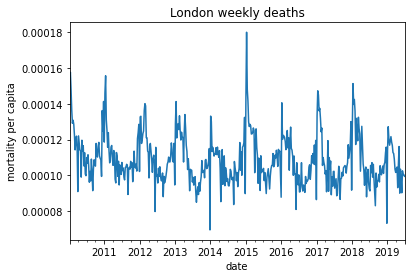

In [8]:
df = linear_df.join(mortality_df).dropna()
df["death_fraction"] = df["weekly_deaths"]/df["total_population"]
df["death_fraction"].plot(legend=False, title="London weekly deaths").set_ylabel("mortality per capita")
plt.show()

In [10]:
df.to_csv(path.join(path.join(path.abspath(""), "mortality_data"), "weekly_mortality_percapita_London.csv"))